#Deep Learning with MXNet


Welcome to CIS 545 Homework 5! 

There are many cool frameworks for building deep learning models:  PyTorch, Tensorflow, Theano, MxNet. We need a framework that scales well. Almost all of these have multi-GPU support built in; MxNet provides the easiest abstractions to do this and works well with AWS as well as Colab. I will be building neural networks in MxNet to solve an interesting problem.

Deep learning or neural network architectures have been used to solve a multitude of problems in various different fields like vision, natural language processing, and radiology. 




## Why Deep Learning? 


*   Deep learning unlocks the treasure trove of unstructured big data for those with the imagination to use it
*   Deep learning models have great representational power and are 'universal approximators'


### Deep Learning Applications:


Deep learning has been significantly improved voice command systems (such as Siri and Alexa), as well as healthcare and image identification.

Deep learning has applications across numerous industries, which is why experts think that this technology is the future of almost everything. There are truly deep learning technologies such as Google’s very human-like talking AI, a new theory that cracks the 'black box' of deep learning, and various budding ideas like this one about why human forgetting might be the key to AI. Here are some cool applications of deep learning.

Here's a neural network detecting anomalies in Chest Xrays :




![alt text](https://imgur.com/HKPzrzP.jpg)

Most humans can't tell that this is a case of Pleural Effusion {sounds like medical jargon to engineers like us} but this Neural Network model can detect it very well!

Mask RCNNs in action for detecting objects on the road aiding a self driving vehicle's driving: 
![alt text](https://miro.medium.com/max/3864/1*O4wsvh0CHWjP6IrK9HI_Zg.png)

I will be appling CNNs to solve an image classification problem.

# Setup Skeleton



## MxNet Installation

First, verify that we see a Tesla or other GPU listed here...

In [ ]:
!nvidia-smi

Thu Dec  3 04:40:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip3 install --upgrade mxnet-cu101 gluoncv

In [ ]:
import mxnet as mx
from gluoncv.utils import viz
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from mxnet import np
import shutil

In [ ]:
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

if npx.num_gpus() < 1:
  raise "No GPU is found, please restart your runtime!"

# Section 1 : Indoor Scene Recognition with MXNet
## 1.1 Lots of Data

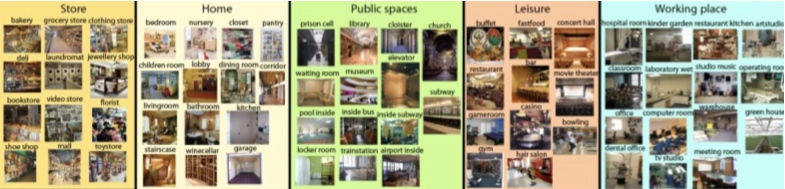

The datset I use is used for the indoor scene recognition problem. Indoor scene recognition is a challenging open problem in high level vision. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g. corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information.
 
The dataset contains 67 Indoor categories. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. 

## Download the dataset
Run the cell below to download the dataset from Google Drive.

In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2020')
HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'HW5')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


Download the data into my Google Drive. 


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

if not os.path.isfile("/content/gdrive/My Drive/CIS545_2020/HW5/data.zip"):
  gdd.download_file_from_google_drive(file_id='1A-dYo1ba1mjTrnH6xjzYrg_fO_GxHjvN',
                                    dest_path='/content/gdrive/My Drive/CIS545_2020/HW5/data.zip')

In [ ]:
!ls "/content/gdrive/My Drive/CIS545_2020/HW5"

data.zip


In [ ]:
!unzip "/content/gdrive/My Drive/CIS545_2020/HW5/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: indoorCVPR_09/Images/studiomusic/solarstudio.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio14.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio16.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio2.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio21.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio87.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio99.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_1.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_2.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_a.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_overall.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_pic_for_website.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studiomusic.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/susustudio.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/trabajo_238115785.jpg 

## 1.1.1 Filter out corrupt and nonexistent images

There are a lot of images in the dataset that aren't valid JPEG images. We need to filter out the invalid images! Complete the check_corrupt function which takes in a filename and returns a boolean indicating if the file is valid. The PIL library will be useful for this verification.




In [ ]:
base_path = '/content/indoorCVPR_09/Images'
train_path = os.path.join(base_path, 'train/')
print(type(train_path))

<class 'str'>


In [ ]:
base_path = '/content/indoorCVPR_09/Images'
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path,'test/')
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

train_file = open("/content/TrainImages.txt", "r") 
from PIL import Image

def check_corrupt(filename):
    #TODO -- also fix the return result!
  try:
    img = Image.open(filename)
    form = img.format in ['PNG', 'JPG', 'JPEG', 'BMP']
    img.verify()
  except Exception:
    form = False
  return not form or img.mode == 'P'

# Check all images in the train file for validity and write the valid ones to train_path
correct_file_count_train = 0
for file in train_file:
    image_path = os.path.join(base_path,file.rstrip('\n'))
    dest_folder = os.path.join(train_path, file.split('/')[0])
    os.makedirs(dest_folder, exist_ok=True)
    dest_path = os.path.join(train_path,file.rstrip('\n'))
    if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
        continue
    correct_file_count_train += 1
    dest = shutil.move(image_path, dest_path)  

correct_file_count_test = 0
test_file = open("/content/TestImages.txt", "r") 
for file in test_file:
    image_path = os.path.join(base_path,file.rstrip('\n'))
    dest_folder = os.path.join(test_path, file.split('/')[0])
    os.makedirs(dest_folder, exist_ok=True)
    dest_path = os.path.join(test_path,file.rstrip('\n'))
    if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
        continue
    correct_file_count_test += 1
    dest = shutil.move(image_path, dest_path)  

# print(correct_file_count_test)

## 1.1.2 Build a dataset class

I created train and test datasets for loading image files stored in a folder structure within train_path and test_path. I made sure that the image pixels  are `float`s in the range `[0,1]` and not `int`egers between `[0,255]` using the transform parameter

I named my datasets `train_dataset` and `test_dataset`.
[Here](https://mxnet.apache.org/versions/1.7.0/api/python/docs/tutorials/packages/gluon/data/datasets.html#Machine-learning-with-Datasets-and-DataLoaders) is a resource I used.


In [ ]:
# TODO: Create train_dataset and test_dataset
def transform(d, l):
  d = d.astype('float32') * (1/255)
  return d, l
  
train_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(train_path, transform=transform)
test_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(test_path, transform=transform)

## 1.1.3 Visualize images from the dataset

I have my training and testing datasets but as humans, we don't really understand binary that well. So let's visualize what the data is by plotting some data points.

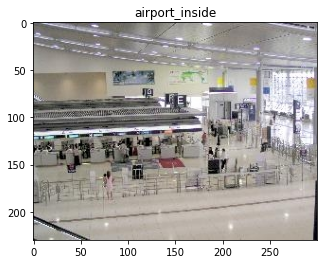

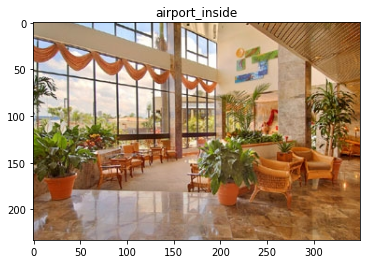

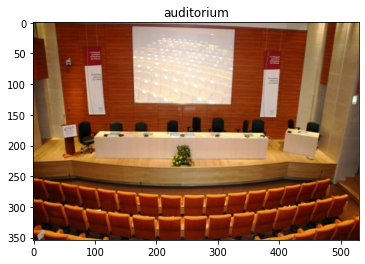

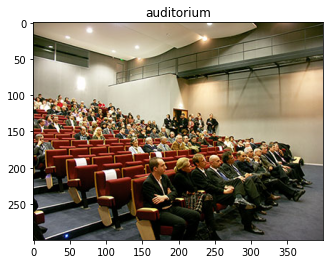

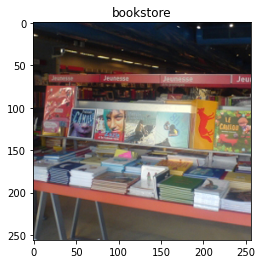

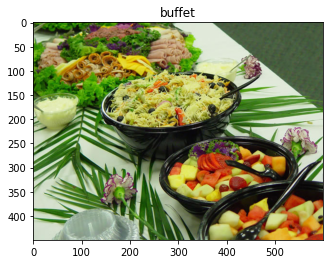

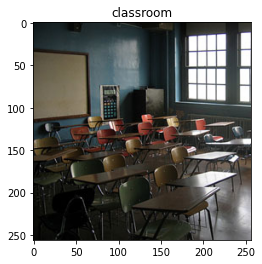

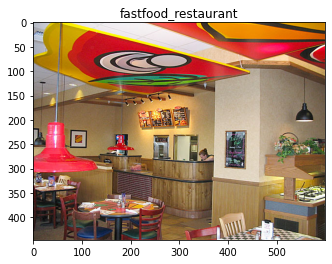

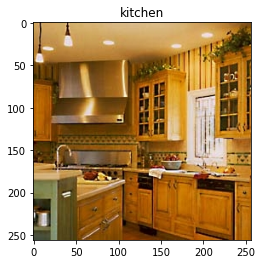

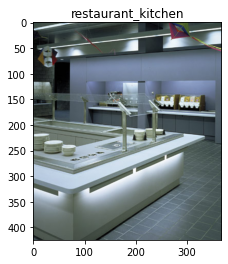

In [ ]:
# Visualize 10 images in the dataset with their labels
%matplotlib inline

import matplotlib.pyplot as plt

sample_idxs = [1, 3, 213, 224, 567, 779, 1052,2000, 3000, 4444]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    plt.imshow(data.asnumpy())
    plt.title(train_dataset.synsets[label])
    plt.show()


We can see that these images are all different sizes and some examples can be really hard to classify - like the airport inside class!

## 1.1.4 Class frequency distributions 
I created a frequency distribution of the classes in the training dataset. I  created a dictionary with the number of faces belonging to each of the emotions. The key for the dictionary is the name of the scene and the value should be the frequency in the train dataset.

In [ ]:
def create_frequency_dict(train_dataset):
  s = {}
  #TODO: Create the scene frequency distribution
  classes = train_dataset.synsets
  for ind_name in classes:
    s[ind_name] = 0
    for (filename, i) in train_dataset.items:
      ind_name = classes[i]
      prev = s.get(ind_name)
      if prev == None:
        prev = 0

      # add count  
      s[ind_name] = prev + 1
      
    return s

scene_frequency_dict = create_frequency_dict(train_dataset)
print(scene_frequency_dict)

{'airport_inside': 80, 'artstudio': 80, 'auditorium': 82, 'bakery': 81, 'bar': 82, 'bathroom': 82, 'bedroom': 79, 'bookstore': 80, 'bowling': 80, 'buffet': 79, 'casino': 81, 'children_room': 82, 'church_inside': 81, 'classroom': 82, 'cloister': 80, 'closet': 81, 'clothingstore': 82, 'computerroom': 80, 'concert_hall': 80, 'corridor': 79, 'deli': 81, 'dentaloffice': 79, 'dining_room': 82, 'elevator': 79, 'fastfood_restaurant': 80, 'florist': 81, 'gameroom': 80, 'garage': 81, 'greenhouse': 80, 'grocerystore': 79, 'gym': 82, 'hairsalon': 79, 'hospitalroom': 80, 'inside_bus': 77, 'inside_subway': 79, 'jewelleryshop': 78, 'kindergarden': 80, 'kitchen': 79, 'laboratorywet': 78, 'laundromat': 78, 'library': 79, 'livingroom': 80, 'lobby': 80, 'locker_room': 79, 'mall': 80, 'meeting_room': 78, 'movietheater': 80, 'museum': 77, 'nursery': 80, 'office': 79, 'operating_room': 81, 'pantry': 80, 'poolinside': 79, 'prisoncell': 80, 'restaurant': 80, 'restaurant_kitchen': 77, 'shoeshop': 81, 'stairsca

If the class distribution is uniform, we don't need to address class imbalance.

## 1.1.5 Create Dataloader objects

Data loaders create data batches and perform transformations on the images. 

Since the images are different sizes, we need to resize them to the same value. I wrote a `transform`ation to resize the image to 224 x 224. I also added a transformation to convert the image to a *tensor* -- one of the building blocks of neural network operations. Tensors are like numpy arrays with a gradient aspect. 

Steps:
 
*   Defined a composition of transformations to first resize the image and then convert to tensors
*   Next, created train and test data loaders, apply the transformations to the train and test datasets respectively. Passed in the batch size and whether or not you want to shuffle the data. 

Set `shuffle = True` for the train and `False` for the test set. 
* Used a batch size of 32 for the training loader.
* Used a batch size of 1 for the test set.

[Referred to](https://mxnet.apache.org/api/python/docs/api/gluon/data/vision/transforms/index.html#mxnet.gluon.data.vision.transforms.Compose) the transformation documentation


In [ ]:
from mxnet.gluon.data import DataLoader

# TODO: Define the transformation and the train and test loaders
transforms = [mx.gluon.data.vision.transforms.Resize(size = (224, 224)), mx.gluon.data.vision.transforms.ToTensor()]
transformer = mx.gluon.data.vision.transforms.Compose(transforms)

train_dataset = train_dataset.transform_first(transformer)
test_dataset = test_dataset.transform_first(transformer)

train_shuffle = True
test_shuffle = False

train_loader = DataLoader(train_dataset, batch_size=32, shuffle = train_shuffle)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle = test_shuffle)

# Section 2: Xlassifiers!

We have the data we need to train a scene classifier. I will start simple with a logistic regression classifier as a baseline for our performance before we move onto more complex neural networks. 

## 2.1.1 Logical Logistic Regression - Baseline

I first tried solving this problem with a Logistic Regression classifier solving the multiclass classification problem.

I defined a logistic regression model in Apache MxNet, trained it on the training set, and evaluated the performance on the test set.

*Note*: With MxNet, data (tensors) are typically in `ndarrays`.  However, certain functions expect Numpy arrays.  Occasionally you'll get an error when you pass an array into a function, where it tells you to call `as_np_ndarray()` or `as_nd_ndarray()`. 


### Model Definition

I defined my first model in mxnet. I used  `gluon` and `autograd` modules and to create layers in a neural network.

The first model is a logistic regression model with the number of outputs equal to the number of classes in the model. I completed the construct net function with the logistic regression model definition.

In [ ]:
from mxnet import gluon, autograd, ndarray

def construct_net():
    n = gluon.nn.Sequential()
    with n.name_scope():
        n.add(gluon.nn.Dense(units = len(scene_frequency_dict)))
    return n

net = construct_net()

# Set the context to use the available GPUs, otherwise just use a CPU
ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()

Needed to initialize the model weights and the context, so I called the net initialize function with Xavier Initialization, and set the ctx variable with the context defined above

In [ ]:
net.initialize(mx.init.Xavier(), ctx=ctx)

Model Summary:

In [ ]:
x = mx.sym.var('data')
sym = net(x.as_np_ndarray())
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
sequential0_dense0_fwd(FullyConnected)                                      67          data                            
Total params: 67
________________________________________________________________________________________________________________________


This is a multi-class classification problem, so we will use the *categorical cross-entropy* loss function. It is defined as:

$$L(y,\hat y)=-\sum_{j=0}^M\sum_{i=0}^{N}(y_{ij} log(\hat y_{ij}))$$

Luckily, we don't have to write it ourselves, we will use the implementation within Mxnet and Gluon.

Let's first define our criterion i.e. the loss function we want to optimize for.

Read more about gluon loss functions [here](https://mxnet.apache.org/api/python/docs/api/gluon/loss/index.html).

In [ ]:
# TODO: Define a gluon Softmax Cross Entropy object, name this 'criterion', 
# the softmax indicates that the loss function does a softmax first to get the probabilities
# and then computes the Cross EntropyLoss
ctr = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label = True)
criterion = ctr

Next, we define a trainer object, which includes an optimizer - we will use a stochastic gradient descent optimizer to optimize for our criterion and update our weights. 
We need 3 parameters while defining a gluon optimizer. 


1.   Trainable parameters in the model - net.collect_params() gives you all these parameters
2.   An optimizer - 'sgd' or 'adam'. For this task, you'll have better luck with the Adam adaptive optimizer than with stochastic gradient descent aka 'sgd'.
3.   Optimizer params - A dictionary with parameters for your optimizer. We only need to specify the learning rate parameter within this dictionary.

The learning rate is a hyperparameter that you should train for. You should start with a small learning rate like 0.001.

Read more about the trainer object [here](https://mxnet.apache.org/api/python/docs/api/gluon/trainer.html).




In [ ]:
train = gluon.Trainer(params=net.collect_params(), optimizer='adam', optimizer_params={'learning_rate': 0.001})
trainer = train

### Train Model

Next, we need to iterate through our training data multiple times to optimize our weights. Each of the iterations is called an epoch. 

We will write a training loop now. Here is the pseudocode for the training loop: 

1. Define an [accuracy metric ](https://mxnet.apache.org/api/python/docs/api/metric/index.html) to measure performance.
1.   Repeat the following for a number of epochs
2.   Iterate through the mini batches in the training dataloader
3.   Each minibatch object will be a tuple `(data, labels)`
4.   Each minibatch has a number of images and a number of labels (batch size number of images and labels in each minibatch). Thus each data object will be of the shape `(BATCH_SIZE, 3, 224, 224)`. The 3 corresponds to the number of channels - RGB and the labels array would be of size `(BATCH_SIZE)`
5.   Since our model requires linear inputs and not multiple channels, flatten the image in the batch. The reshape function will help you to do this.
6.   Send the data and label to the GPU. The `as_in_ctx` with the ctx defined above will help you to do this.
7.   Compute the model outputs for the flattened data using the net object defined above
8.   Compute the loss function with criterion we previously defined
9.   Compute the accuracy using the metric object defined above.
10.  Backpropogate through the computed loss value. This would compute the gradients for each of the model parameters.
11.  Use a trainer to perform an optimizer step - this updates the weights based on the computed gradients wrt the loss function.
12.  To see how your accuracy improves and the loss decreases, after each epoch print out the accuracy and the loss for that epoch. 


You should also plot your training accuracies and training loss function vs epochs. The plot is worth 5 points!


Train your logistic regression model for 10 epochs.

In [ ]:
from mxnet import gluon, autograd, ndarray


#TODO: Define a training function which trains the passed network for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_network(net, train_loader, criterion, trainer, metric, epochs = 10):
  accuracies_list = []
  losses_list = []
  start_pos = 1
  #TODO: Define your training loop here
  for epoch in range(epochs):
    losses = []
    for batch_num, (d, l) in enumerate(train_loader, start = start_pos):
      d = mx.ndarray.reshape(d.as_nd_ndarray(), shape = (len(d), 3*224*224))
      d = d.as_np_ndarray().as_in_ctx(ctx)
      l = l.as_in_ctx(ctx)
      
      with autograd.record():
        out = net(d)
        curr_loss = criterion(out, l)
        curr_loss.backward()

      trainer.step(d.shape[0], ignore_stale_grad = True)
      metric.update(l, out.as_nd_ndarray())
      losses.append(float(curr_loss.as_np_ndarray().flatten().mean()))

    # Calculate for outputs  
    name, final_training_accuracy = metric.get()
    final_training_loss = sum(losses) / len(losses)

    # Calculate for outputs
    accuracies_list.append(final_training_accuracy)
    losses_list.append(final_training_loss)

    # Calculate for outputs
    # print("Accuracy is equal to: ", final_training_accuracy, "Loss is equal to:", str(final_training_loss))
    metric.reset()

  return final_training_loss, final_training_accuracy, accuracies_list, losses_list


epochs = 10
metric  =  mx.metric.Accuracy(label_names = scene_frequency_dict.keys)
lr_training_loss, lr_training_accuracy, accuracies_list, losses_list = train_network(net, train_loader, criterion, trainer, metric, epochs)

print("Logistic Regression - the training loss is ", str(lr_training_loss))
print("Logistic Regression - the training accuracy is ", str(lr_training_accuracy))


Logistic Regression - the training loss is  3.3860105006467727
Logistic Regression - the training accuracy is  0.21630211254440082


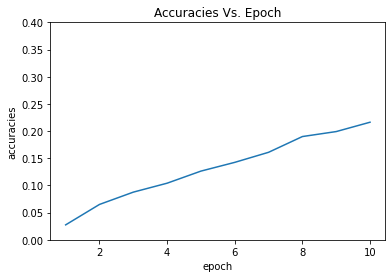

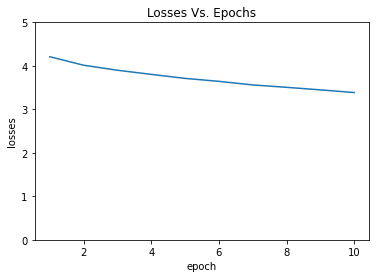

In [ ]:
# TODO: Plot your training accuracies and training loss function vs epochs!
from matplotlib import pyplot as plt

epochs_list = range(1, 11)
epochs_list = list(epochs_list)

epochs_accuracies = plt.figure(1)
plt.plot(epochs_list, accuracies_list)
plt.ylabel('accuracies')
plt.title('Accuracies Vs. Epoch')
plt.ylim(0, 0.4)
plt.xlabel('epoch')

epochs_losses = plt.figure(2)
plt.plot(epochs_list, losses_list)
plt.ylabel('losses')
plt.xlabel('epoch')
plt.title('Losses Vs. Epochs')
plt.ylim(0, 5)
plt.show()



Is your model learning? Is the loss decreasing? Is it able to classifiy better after training?


### Evaluate Model

Evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

Note:  Please don't report false numbers for the accuracy as we will be reviewing these manually and if if there is a manipulation with the accuracy computation, you will get a 0 for the entire section.


In [ ]:
def test_model(net, criterion, test_loader, metric):
    #TODO
  losses = []
  start_pos = 1
  for batch_num, (d, l) in enumerate(test_loader, start = start_pos):
    d_shape = (len(d), 3*224*224)
    d = mx.ndarray.reshape(d.as_nd_ndarray(), shape = d_shape)
    d = d.as_np_ndarray().as_in_ctx(ctx)
    l = l.as_in_ctx(ctx)
    
    with autograd.record():
      out = net(d)
      curr_loss = criterion(out, l)
      curr_loss.backward()
    metric.update(l, out.as_nd_ndarray())
    
    losses.append(float(curr_loss.as_np_ndarray().flatten().mean()))

  # Calculate for outputs  
  n, training_accuracy = metric.get()
  avg_losses = sum(losses) / len(losses)
  # print("Accuracy is equal to:", training_accuracy, "Loss is equal to:", str(avg_losses))
  metric.reset()

  # Calculate for outputs
  curr_losses = losses
  avg_curr_losses = sum(curr_losses) / len(curr_losses)
  testing_loss = avg_curr_losses
  testing_accuracy = training_accuracy
  return  testing_loss, testing_accuracy

# metric  =  #TODO: Define an accuracy metric
lr_testing_loss, lr_testing_accuracy = test_model(net, criterion, test_loader, metric)

print("Logistic Regression - the testing loss is ", str(lr_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(lr_testing_accuracy))

Logistic Regression - the testing loss is  3.9713464218011683
Logistic Regression - the testing accuracy is  0.07571214392803598


Does the logistic regression fit well to the data? Think about whether this is underfitting or overfitting? Think about if we need more representational power or we need more regularization to make it better?

## 2.1.2 Feedforward Neural Networks 

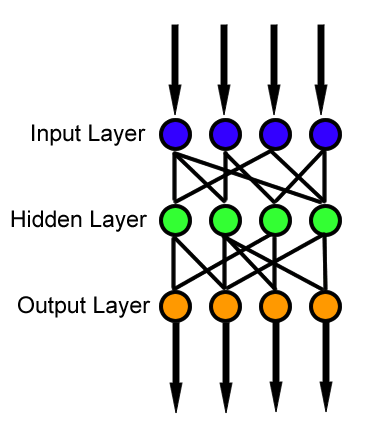

Since logistic regression isn't that great at fitting our classification problem, we need more representation power. We will now define a feedforward neural network


Complete the `create_ff_net` function below to define a feedforward neural network with at least 2 hidden layers. Note that the last layer must have the number of classes as the output size. You will also need to initialize the network, create a new trainer object with the parameters of the feedforward network. Use a ReLU activation function for the hidden layers. 


In [ ]:
from mxnet import gluon, autograd, ndarray
relu = "relu"
adam = 'adam'
learning_rate = 'learning_rate'
val = 0.001

def construct_ff_net():
    ff_net = gluon.nn.Sequential()
    
    # Calculate for outputs
    with ff_net.name_scope():
      ff_net.add(gluon.nn.Dense(1000, activation = relu),
        gluon.nn.Dense(1000, activation = relu),
          gluon.nn.Dense(units = len(scene_frequency_dict)))
      
    return ff_net

# Calculate for outputs 
ff_net  = construct_ff_net()
#TODO: Initialize the network
ff_net.initialize(mx.init.Xavier(), ctx=ctx)
# type(ff_net)

trainer = gluon.Trainer(params = ff_net.collect_params(), optimizer = adam, optimizer_params={'learning_rate': val})
ffn_trainer = trainer

Print the model summary for the fully connected network.

In [ ]:
x = mx.sym.var('data')
# type(x)
sym = ff_net(x.as_np_ndarray())
# type(sym)
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
sequential1_dense0_fwd(FullyConnected)                                      1000        data                            
________________________________________________________________________________________________________________________
sequential1_dense0_relu_fwd(Activation)                                     0           sequential1_dense0_fwd          
________________________________________________________________________________________________________________________
sequential1_dense1_fwd(FullyConn

Now train this network using the train network function defined above. Create plots for the training accuracy and training loss vs the number of epochs.


In [ ]:
#TODO: Train the feedforward neural network on the training set using the train_network function
ffn_training_loss, ffn_training_accuracy, accuracies_list, losses_list = train_network(ff_net, train_loader, criterion, ffn_trainer, metric, 10)

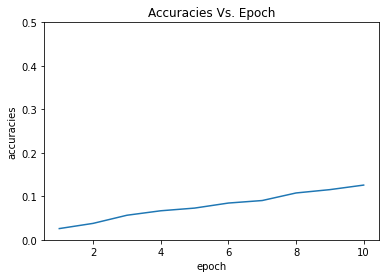

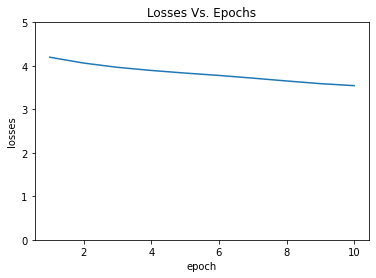

In [ ]:
#TODO: plot curves
epochs_list = range(1, 11)
epochs_list = list(epochs_list)

epochs_accuracies = plt.figure(1)
plt.plot(epochs_list, accuracies_list)
plt.ylabel('accuracies')
plt.title('Accuracies Vs. Epoch')
plt.ylim(0, 0.5)
plt.xlabel('epoch')

epochs_losses = plt.figure(2)
plt.plot(epochs_list, losses_list)
plt.ylabel('losses')
plt.xlabel('epoch')
plt.title('Losses Vs. Epochs')
plt.ylim(0, 5)
plt.show()

Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set

In [ ]:
# TODO: Compute performance on the test set using the test_network function created before
ffn_testing_loss, ffn_testing_accuracy = test_model(ff_net, criterion, test_loader, metric)

Does the feedforward network do better than logistic regression? Play around with the network architecture to see how it affects the performance on both the train and test data.

## 2.1.3 Convoluted Convolutional Neural Networks
**So, what are CNNs?**

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. 

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

If you wanna know more about how CNNs function and see some cool visualizations, we would highly recommend [this](http://cs231n.github.io/convolutional-networks/) page


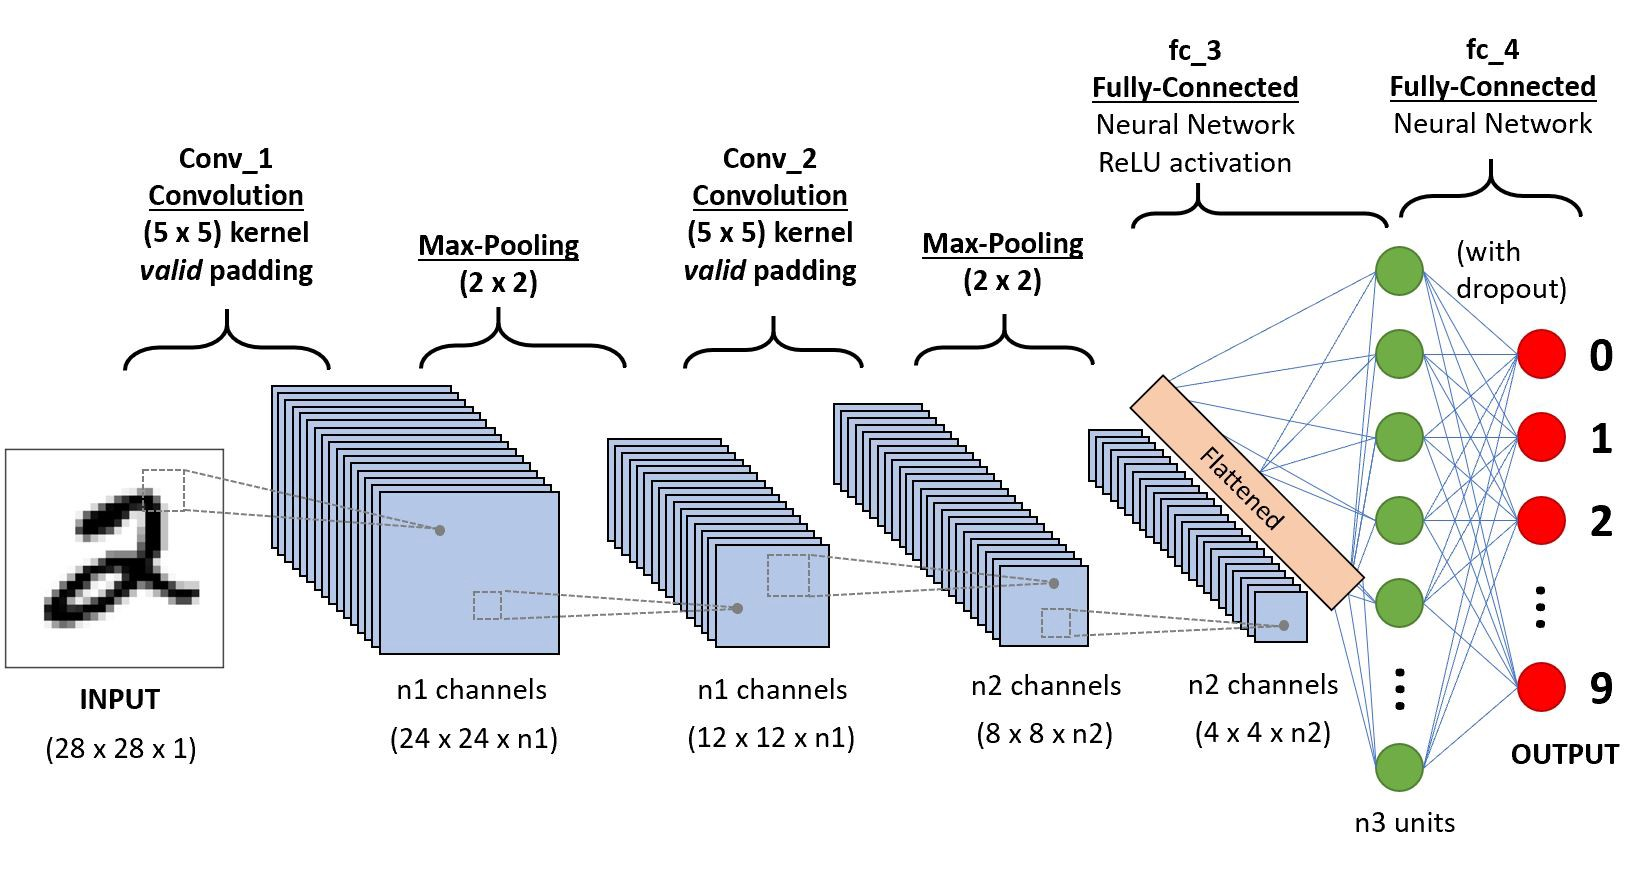


We will define the architecture for the CNN we will be using. The components of CNNs are: 


*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

Define a CNN model with Mxnet and Gluon with a convolutional layer followed by an activation function and a max pool, for one or more layers; then flatten the output from the convolutional layers and pass it through one or more fully connected or 'dense' layers and activation functions after all but the last layer. Note that the output shape from the last layer must be the same as the number of classes.

You can find some examples of this here: https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html#Faster-modeling-with-gluon.nn.Sequential

In [ ]:
import mxnet.ndarray as F

x = (2, 2)
y = (5, 5)
z = (0, 0)
relu = "relu"

def construct_conv_net():
  # TODO
  conv_net = gluon.nn.Sequential()
  with conv_net.name_scope():
    conv_net.add(gluon.nn.Conv2D(channels = 64, kernel_size = y, padding = z, activation = relu),
                 gluon.nn.MaxPool2D(pool_size = x, strides = x),
                 gluon.nn.Conv2D(channels = 64, kernel_size = y, padding = z, activation = relu),
                 gluon.nn.MaxPool2D(pool_size = x, strides = x),
                 gluon.nn.Flatten(),
                 gluon.nn.Dense(512, activation = relu),
                 gluon.nn.Dense(units = len(scene_frequency_dict)))
  return conv_net


Once again, we ask you to create a network, initialize it and create a trainer for it.

In [ ]:
#TODO : Initialize network, initialize the criterion and the trainer

adam = 'adam'
val = 0.001

cnn = construct_conv_net()

# initialize network
cnn.initialize(mx.init.Xavier(magnitude = 2.24), ctx = ctx)
# initialize criterion
cnn_criterion = gluon.loss.SoftmaxCrossEntropyLoss()
# initialize trainer
cnn_trainer = gluon.Trainer(params = cnn.collect_params(), optimizer = adam, optimizer_params = {'learning_rate': val})

Write another function to train a convolutional neural network on the train data given the network, trainer and criterion. Train the CNN for 10-25 epochs. 

Plot the training loss and accuracy curves.

Note that there will be a slight difference from training a feedforward network, because here you will the image information in separate chanels as the input rather than a single flattened input.

Note also that you may have to experiment with the number and widths of the layers, until you get satisfactory performance.  To give a hint of what's possible, our classifier achieve an accuracy score of 0.94 on this part (i.e., with the training dataset).

In [ ]:
from mxnet import gluon, autograd, ndarray


#TODO: Define a training function which trains the passed network for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_cnn(net, train_loader, criterion, trainer, metric, epochs = 10):
    #TODO: Define your training loop here
    accuracies_list = []
    losses_list = []
    for e in range(epochs):
      for i, (d, l) in enumerate(train_loader):
        d = d.as_in_context(ctx)
        l = l.as_in_context(ctx)
        
        with autograd.record():
          out = net(d)
          loss = criterion(out, l)

        loss.backward()
        trainer.step(d.shape[0])
        
        metric.update(l, out.as_nd_ndarray())
        
        #  avg of losses moves
        curr_loss = float(loss.as_np_ndarray().flatten().mean())
        move_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - .01) * move_loss + .01 * curr_loss)

      name, training_accuracy = metric.get()
      metric.reset()
      accuracies_list.append(training_accuracy)
      losses_list.append(move_loss)
      # print("Accuracy is equal to: ", training_accuracy, "Loss is equal to: ", str(move_loss))

    #calculate for output
    final_training_loss = move_loss
    return final_training_loss, training_accuracy, accuracies_list, losses_list

cnn_training_loss, cnn_training_accuracy,  accuracies_list, losses_list = train_cnn(net, train_loader, criterion, train, metric, epochs)

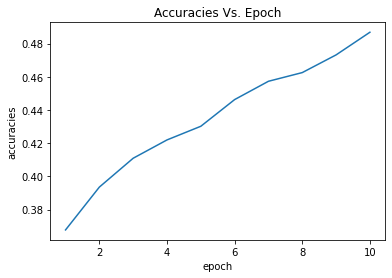

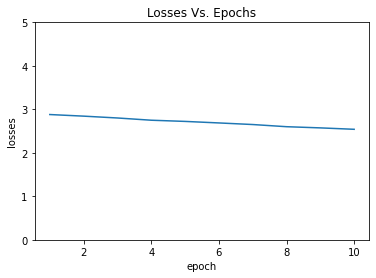

In [ ]:
# TODO: don't forget to plot training loss + accuracy curves!
#TODO: plot curves
epochs_list = range(1, 11)
epochs_list = list(epochs_list)

epochs_accuracies = plt.figure(1)
plt.plot(epochs_list, accuracies_list)
plt.ylabel('accuracies')
plt.title('Accuracies Vs. Epoch')
plt.xlabel('epoch')

epochs_losses = plt.figure(2)
plt.plot(epochs_list, losses_list)
plt.ylabel('losses')
plt.xlabel('epoch')
plt.title('Losses Vs. Epochs')
plt.ylim(0, 5)
plt.show()

Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

In [ ]:
# TODO: Compute performance on the test set, you may need to write a new function modifying test_network without the flattening aspect
def test_cnn(net, criterion, test_loader, metric):

  for i, (d, l) in enumerate(train_loader):
    d = d.as_in_context(ctx)
    l = l.as_in_context(ctx)
    with autograd.record():
        out = net(d)
        curr_loss = criterion(out, l)
    curr_loss.backward()

    metric.update(l, out.as_nd_ndarray())
     
    curr_loss = float(curr_loss.as_np_ndarray().flatten().mean())
    move_loss = (curr_loss if (i == 0)
                  else (1 - .01) * move_loss + .01 * curr_loss)

  # calculate for output  
  n, training_accuracy = metric.get()
  metric.reset()

  training_loss = move_loss
  return training_loss, training_accuracy

cnn_testing_accuracy, cnn_testing_loss = test_cnn(cnn, cnn_criterion, test_loader, metric)